## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [97]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [98]:
df=pd.read_csv('ab_data.csv')
df.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


b. Use the below cell to find the number of rows in the dataset.

In [99]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [100]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [101]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [102]:
notmatch = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]
notmatch

3893

f. Do any of the rows have missing values?

In [103]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [104]:
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [105]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [106]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [107]:
df2.user_id.duplicated().sum()

1

In [108]:
print(df2.user_id.value_counts().index[0])

773192


c. What is the row information for the repeat **user_id**? 

In [109]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [110]:
#I will Remove one of the duplicate lines number 1899
df2.drop(labels = 1899, axis=0, inplace=True)

In [111]:
#check if the label removed

df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [112]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [113]:
p_conv_control = df2.query("group == 'control'").converted.mean()
p_conv_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [114]:
p_conv_treatment = df2.query("group == 'treatment'").converted.mean()
p_conv_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [115]:
p_rec_newpage=(df2['landing_page'] == "new_page").mean()
p_rec_newpage

0.5000619442226688

In [116]:
observed_mean = p_conv_treatment - p_conv_control
observed_mean

-0.0015782389853555567

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

Based on the results , there is no sufficient evidence that the treatment page leads to more conversions as the probability of conversion of **[treatment group "11.88"]** < **[control group"12.04"]**.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_0: p_{new} \leq p_{old} \Leftrightarrow H_1: p_{new} - p_{old} \leq 0 $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br> Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [117]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [118]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [119]:
n_new = (df2.query("group == 'treatment'")).shape[0]
n_new

145310

d. What is $n_{old}$?

In [120]:
n_old =(df2.query("group == 'control'")).shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [121]:
newpage_convert = np.random.binomial(1, p_new, n_new)
newpage_convert

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [122]:
oldpage_convert = np.random.binomial(1, p_old, n_old)
oldpage_convert

array([1, 1, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [123]:
p_new = newpage_convert.mean()
p_old = oldpage_convert.mean()

#know calculate the diffrences
p_diffrence = p_new - p_old
p_diffrence

0.0014984034208767594

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [124]:
newpage_converted = np.random.binomial(n_new, p_new,  10000)/n_new
oldpage_converted= np.random.binomial(n_old, p_old,  10000)/n_old


In [125]:
p_diffs= newpage_converted - oldpage_converted
p_diffs

array([0.00066556, 0.00153954, 0.00143643, ..., 0.0012093 , 0.0031502 ,
       0.00132638])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

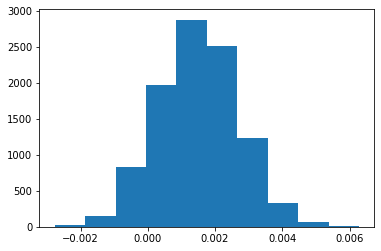

In [126]:
plt.hist(p_diffs);

> P-diffs follow **normal distribution** and it's as I expected.
it follows Central limit theory , with large enough sample size, sample distribution of mean will be normally distributed.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [127]:
# In order to calculate the p_value 
null_vals = np.random.normal(0, p_diffs.std(), 10000)

In [128]:
# Obs mean calculated in the first part by substracting p_conv_treatment from p_conv_control
p_value = (null_vals > observed_mean).mean()
p_value

0.9028

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?


> **-** the significance level of this hypothesis test is $\alpha = 0.05$. It means any p-value > 0.05 (5%) it will not reject the null hypothesis..
The **p-value is 0.9028** which is bigger than  $\alpha = 0.05$ , that suggests that the behavior of tested value "the distinction in change proportions b\w the old and new pages" as per the null hypothesis, meaning that the old page conversion proportions >= to those of new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [129]:
import statsmodels.api as sm

convert_old = df2.query("converted == 1 and landing_page == 'old_page'").user_id.nunique()
convert_new = df2.query("converted == 1 and landing_page == 'new_page'").user_id.nunique()


In [130]:
n_old = df2.landing_page.value_counts()[1]
n_new = df2.landing_page.value_counts()[0]

print (convert_old , n_old)
print (convert_new , n_new)

17489 145274
17264 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [131]:
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new, convert_old],  nobs=[n_new, n_old])
z_score, p_value 

(-1.3109241984234394, 0.18988337448195103)

In [132]:
from scipy.stats import norm

In [133]:
 # To find out the critical value at confidence-95% 
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Since the value of z-score is -1.31 < 1.9599 "Critical value, the null hypthesis which suggest that "the old page is better or equal than the new page" is accepted (it means we fail to reject the null hypothesis)**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since the focus will be in two categorical different output,Logistic Regression model is the best choice to compare the two dummy variables.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [134]:
df2['intercept']=1

In [135]:
#Create dummies variable
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [136]:
# statsmodle already imported in the previous part
log_model = sm.Logit(df2['converted'], df2[['treatment','intercept']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [137]:
logit_result = log_model.fit()
logit_result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        08:37:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?


**The p-value of both tests are diffrent , and that simply because of the diffrent hypothesis selected for each one.**
**The Hypothesis of regression mpdel will be as below :**

$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} \neq 0$$


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**
1. We'd want to have more predictors of linearly that is independent linked to convertion variables , we can have high probaboilities to estimate who are more likely to convert.

2. Other factors should be consider into the model and it could effect the conversions as well. For Example, to find put the most part of the day that users are more likely to convert by using the timestamp metric.

**Disadvantage:**
We considreing to add more variables into the model. By adding those variables we may face **Multicollinearity** which might effect the hypothesis testing result negatively.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [138]:
df_countries= pd.read_csv('./countries.csv')

df3 = pd.merge(df2,df_countries,on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [139]:
# Create the dummy variables
df3[['CA','UK','US']]=pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [140]:
# Fit the Linear Model And Obtain the Results
liner_mod = sm.Logit(df3['converted'],df3[['UK','US','CA']])
result=liner_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [141]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 Jun 2020   Pseudo R-squ.:               1.521e-05
Time:                        08:37:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
UK            -1.9868      0.011   -174.174      0.000      -2.009      -1.964
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -2.0375      0.026    -78.364      0.000      -2.088      -1.987
==============================================================================
"""

**The result doesn't show Statstical Signficance. There is no strong relation between the convertion propotion and the user's city..**

<a id='conclusions'></a>
## Conclusions

**In this project different techniques used to prove the null hypothesis : the old page is better based on the information available this data analysis boundaries because of variables excluded from the information.**



# Refrences 

https://stackoverflow.com/questions/11587782/creating-dummy-variables-in-pandas-for-python

https://pandas.pydata.org/pandas-docs/stable/merging.html

udacity- Hypothesis lesson: https://classroom.udacity.com/nanodegrees/nd002-connect/parts/72efb391-6949-4264-8220-dd6f6a524e26/modules/82c7c576-88f5-43b6-80fc-c53378527a2d/lessons/ad8aca80-f444-4479-8848-5b07bafaf66c/concepts/8d45eff6-5278-4f69-8440-6569ef1628b2